In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import requests
import time

from statsmodels.stats.outliers_influence import variance_inflation_factor

### Loading Dataset

In [2]:
# List of all individual country codes from the World Bank (ISO 2-letter codes)
# Full list can be found here: https://datahelpdesk.worldbank.org/knowledgebase/articles/906519
country_codes = [
    'AF', 'AL', 'DZ', 'AS', 'AD', 'AO', 'AI', 'AG', 'AR', 'AM', 'AW', 'AU', 'AT', 'AZ', 'BS', 'BH', 'BD', 'BB', 'BY', 'BE', 'BZ', 'BJ', 'BM', 'BT', 'BO', 'BA', 'BW', 'BR', 'BN', 'BG', 'BF', 'BI', 'KH', 'CM', 'CA', 'CV', 'KY', 'CF', 'TD', 'CL', 'CN', 'CO', 'KM', 'CG', 'CD', 'CR', 'CI', 'HR', 'CU', 'CY', 'CZ', 'DK', 'DJ', 'DM', 'DO', 'EC', 'EG', 'SV', 'GQ', 'ER', 'EE', 'ET', 'FO', 'FJ', 'FI', 'FR', 'GA', 'GM', 'GE', 'DE', 'GH', 'GR', 'GD', 'GU', 'GT', 'GN', 'GW', 'GY', 'HT', 'HN', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE', 'IL', 'IT', 'JM', 'JP', 'JO', 'KZ', 'KE', 'KI', 'KP', 'KR', 'KW', 'KG', 'LA', 'LV', 'LB', 'LS', 'LR', 'LY', 'LI', 'LT', 'LU', 'MG', 'MW', 'MY', 'MV', 'ML', 'MT', 'MH', 'MR', 'MU', 'MX', 'FM', 'MD', 'MC', 'MN', 'ME', 'MA', 'MZ', 'MM', 'NA', 'NR', 'NP', 'NL', 'NZ', 'NI', 'NE', 'NG', 'NO', 'OM', 'PK', 'PW', 'PA', 'PG', 'PY', 'PE', 'PH', 'PL', 'PT', 'PR', 'QA', 'RO', 'RU', 'RW', 'WS', 'SM', 'ST', 'SA', 'SN', 'RS', 'SC', 'SL', 'SG', 'SK', 'SI', 'SB', 'SO', 'ZA', 'SS', 'ES', 'LK', 'SD', 'SR', 'SE', 'CH', 'SY', 'TW', 'TJ', 'TZ', 'TH', 'TL', 'TG', 'TO', 'TT', 'TN', 'TR', 'TM', 'TV', 'UG', 'UA', 'AE', 'GB', 'US', 'UY', 'UZ', 'VU', 'VE', 'VN', 'YE', 'ZM', 'ZW'
]

# Define the indicators (based on World Bank codes)
indicators = {
    
    'GDP Growth (%)': 'NY.GDP.MKTP.KD.ZG',
    'FDI (% of GDP)': 'BX.KLT.DINV.WD.GD.ZS',
    'Inflation (%)': 'FP.CPI.TOTL.ZG',
    'Unemployment (%)': 'SL.UEM.TOTL.ZS',
    'Trade Balance (% of GDP)': 'NE.RSB.GNFS.ZS'
}

# Define parameters
start_year = 2000
end_year = 2023
base_url = "https://api.worldbank.org/v2/country/{}/indicator/{}?date={}:{}&format=json&per_page=1000"

In [3]:
# Reduce batch size and split by indicator
batch_size = 5

# Storage for fetched data
data = []

# Loop over indicators one at a time
for name, code in indicators.items():
    print(f"Fetching data for: {name}")
    
    for i in range(0, len(country_codes), batch_size):
        batch = country_codes[i:i + batch_size]
        countries = ";".join(batch)
        url = base_url.format(countries, code, start_year, end_year)
        
        response = requests.get(url)
        if response.status_code == 200:
            json_data = response.json()
            if len(json_data) > 1:
                for entry in json_data[1]:
                    data.append({
                        'Country': entry['country']['value'],
                        'Year': entry['date'],
                        'Indicator': name,
                        'Value': entry.get('value', None)
                    })
        else:
            print(f"Failed to fetch {name} for countries: {countries} (Status code: {response.status_code})")
        
        # Avoid hitting request limit
        time.sleep(0.2)

# Convert to DataFrame
df = pd.DataFrame(data)

# Reshape to wide format (optional)
df_pivot = df.pivot(index=['Country', 'Year'], columns='Indicator', values='Value').reset_index()


Fetching data for: GDP Growth (%)
Fetching data for: FDI (% of GDP)
Fetching data for: Inflation (%)
Fetching data for: Unemployment (%)
Fetching data for: Trade Balance (% of GDP)


In [4]:
df_pivot.isna().sum()

Indicator
Country                       0
Year                          0
FDI (% of GDP)              578
GDP Growth (%)              125
Inflation (%)               616
Trade Balance (% of GDP)    618
Unemployment (%)            459
dtype: int64

In [5]:
df_pivot.shape

(4680, 7)

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_pivot["Country"].value_counts())

Country
Afghanistan                  24
Romania                      24
Myanmar                      24
Namibia                      24
Nauru                        24
Nepal                        24
Netherlands                  24
New Zealand                  24
Nicaragua                    24
Niger                        24
Nigeria                      24
Norway                       24
Oman                         24
Pakistan                     24
Palau                        24
Panama                       24
Papua New Guinea             24
Paraguay                     24
Peru                         24
Philippines                  24
Poland                       24
Portugal                     24
Puerto Rico                  24
Mozambique                   24
Morocco                      24
Montenegro                   24
Malaysia                     24
Lebanon                      24
Lesotho                      24
Liberia                      24
Libya                        24


In [7]:
df_pivot.head()

Indicator,Country,Year,FDI (% of GDP),GDP Growth (%),Inflation (%),Trade Balance (% of GDP),Unemployment (%)
0,Afghanistan,2000,NaN,NaN,NaN,NaN,7.935
1,Afghanistan,2001,NaN,-9.431974,NaN,NaN,7.953
2,Afghanistan,2002,NaN,28.600001,NaN,NaN,7.930
3,Afghanistan,2003,0.022119,8.832278,NaN,NaN,7.880
4,Afghanistan,2004,-0.013397,1.414118,NaN,NaN,7.899


We have 195 countries

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_pivot[df_pivot.isna().any(axis=1)])

Indicator                    Country  Year  FDI (% of GDP)  GDP Growth (%)  \
0                        Afghanistan  2000             NaN             NaN   
1                        Afghanistan  2001             NaN       -9.431974   
2                        Afghanistan  2002             NaN       28.600001   
3                        Afghanistan  2003        0.022119        8.832278   
4                        Afghanistan  2004       -0.013397        1.414118   
5                        Afghanistan  2005        0.024181       11.229715   
6                        Afghanistan  2006             NaN        5.357403   
7                        Afghanistan  2007             NaN       13.826320   
8                        Afghanistan  2008        0.455360        3.924984   
9                        Afghanistan  2009        0.451889       21.390528   
10                       Afghanistan  2010        1.203118       14.362441   
11                       Afghanistan  2011        0.293025      

In [9]:
df_pivot.isna().sum()

Indicator
Country                       0
Year                          0
FDI (% of GDP)              578
GDP Growth (%)              125
Inflation (%)               616
Trade Balance (% of GDP)    618
Unemployment (%)            459
dtype: int64

Let's save the missing values

In [10]:
df_pivot[df_pivot["FDI (% of GDP)"].isna()]["Country"].value_counts()

Country
Guam                         24
Eritrea                      24
Nauru                        24
San Marino                   24
Monaco                       24
American Samoa               24
Somalia                      24
Korea, Dem. People's Rep.    24
Turkmenistan                 24
Faroe Islands                24
Puerto Rico                  24
Andorra                      24
Chad                         24
Cuba                         24
Micronesia, Fed. Sts.        23
Central African Republic     23
South Sudan                  22
Equatorial Guinea            16
Syrian Arab Republic         13
Rwanda                        9
Venezuela, RB                 9
Marshall Islands              7
Bhutan                        7
Serbia                        7
Montenegro                    7
Afghanistan                   7
Cayman Islands                6
Timor-Leste                   6
Palau                         6
Iraq                          5
Brunei Darussalam             5


In [11]:
df_pivot[df_pivot["GDP Growth (%)"].isna()]["Country"].value_counts()

Country
Korea, Dem. People's Rep.    24
South Sudan                  17
Liechtenstein                14
Djibouti                     14
Eritrea                      12
Venezuela, RB                 9
Faroe Islands                 9
Cayman Islands                7
Yemen, Rep.                   5
American Samoa                4
Guam                          4
Lebanon                       1
San Marino                    1
Syrian Arab Republic          1
Tonga                         1
Bhutan                        1
Afghanistan                   1
Name: count, dtype: int64

In [12]:
df_pivot["GDP Growth (%)"].isna().sum()

125

#### Data Cleaning and Imputation
Strategy: <br>

Remove countries with: <br>
- Any missing values in GDP growth. 
- Any missing values in FDI (% of GDP).

Imputation: <br>
- Linear interpolation → Time-based data (inflation, trade balance).
- Forward/backward fill → Data gaps within the same country.
- Mean/median → Non-time-based data (e.g., unemployment).
- KNN → Final refinement if gaps remain after other methods.

In [13]:
# Remove countries with missing values in GDP Growth
df_pivot = df_pivot[~df_pivot["GDP Growth (%)"].isna()]

# Remove countries with missing values in FDI (% of GDP)
df_pivot = df_pivot[~df_pivot["FDI (% of GDP)"].isna()]

# # Step 1: Calculate number of missing values for each country in FDI
# missing_fdi = df_pivot.groupby("Country")["FDI (% of GDP)"].apply(lambda x: x.isna().sum())

# # Step 2: Keep countries with 3 or fewer missing values
# valid_countries = missing_fdi[missing_fdi <= 3].index
# df_pivot = df_pivot[df_pivot["Country"].isin(valid_countries)]

In [14]:
df_pivot.shape

(4077, 7)

In [15]:
# Find countries with no missing values across all years and variables
complete_countries = df_pivot.groupby('Country').apply(lambda group: group.isna().sum().sum() == 0).reset_index()
complete_countries = complete_countries.loc[complete_countries[0], 'Country']

# Count and print the number of complete countries
print(f"Number of countries with no missing values: {len(complete_countries)}")

Number of countries with no missing values: 122


C:\Users\ACER\AppData\Local\Temp\ipykernel_26684\3267444774.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complete_countries = df_pivot.groupby('Country').apply(lambda group: group.isna().sum().sum() == 0).reset_index()


In [16]:
df_pivot = df_pivot[df_pivot['Country'].isin(complete_countries)]

In [17]:
df_pivot.shape

(2781, 7)

In [18]:
df_pivot.isna().sum()

Indicator
Country                     0
Year                        0
FDI (% of GDP)              0
GDP Growth (%)              0
Inflation (%)               0
Trade Balance (% of GDP)    0
Unemployment (%)            0
dtype: int64

In [19]:
df_pivot.head()

Indicator,Country,Year,FDI (% of GDP),GDP Growth (%),Inflation (%),Trade Balance (% of GDP),Unemployment (%)
24,Albania,2000,4.108776,6.946217,0.050018,-23.223502,19.023
25,Albania,2001,5.285433,8.293313,3.107588,-23.824202,18.570
26,Albania,2002,3.104827,4.536524,7.770526,-26.633836,17.891
27,Albania,2003,3.172708,5.528637,0.484003,-25.325788,16.985
28,Albania,2004,4.750175,5.514668,2.280019,-22.612066,16.306


Load the WGI dataset

Due to mismatches of country names on the 2 datasets, we will rename some of the country name values in the WGI dataset.

In [20]:
# Load the WGI dataset
wgi = pd.read_excel('wgidataset.xlsx')

# Keep only the necessary columns
wgi = wgi[['code', 'countryname', 'year', 'indicator', 'estimate']]

# Create a mapping for mismatched country names
country_mapping = {
    "Côte d'Ivoire": "Cote d'Ivoire",
     "Cape Verde":"Cabo Verde",
     "Czech Republic":"Czechia",
    "Türkiye":"Turkiye" 
}

# Apply the mapping to both datasets
df_pivot['Country'] = df_pivot['Country'].replace(country_mapping)

# Separate corruption and political stability data
corruption = wgi.loc[wgi['indicator'] == 'cc', ['countryname', 'year', 'estimate']]
corruption.rename(columns={'estimate': 'corruption_score'}, inplace=True)

political_stability = wgi.loc[wgi['indicator'] == 'pv', ['countryname', 'year', 'estimate']]
political_stability.rename(columns={'estimate': 'political_stability_score'}, inplace=True)

corruption['countryname'] = corruption['countryname'].replace(country_mapping)
political_stability['countryname'] = political_stability['countryname'].replace(country_mapping)

# Convert year columns to integers
df_pivot['Year'] = df_pivot['Year'].astype(int)
corruption['year'] = corruption['year'].astype(int)
political_stability['year'] = political_stability['year'].astype(int)

# Merge corruption data
df_merged = df_pivot.merge(corruption, left_on=['Country', 'Year'], right_on=['countryname', 'year'], how='left')
df_merged.drop(['countryname', 'year'], axis=1, inplace=True)

# Merge political stability data
df_merged = df_merged.merge(political_stability, left_on=['Country', 'Year'], right_on=['countryname', 'year'], how='left')
df_merged.drop(['countryname', 'year'], axis=1, inplace=True)

# Check result
print(df_merged.head())

# Display missing values after merging
print(df_merged.isna().sum())


   Country  Year  FDI (% of GDP)  GDP Growth (%)  Inflation (%)  \
0  Albania  2000        4.108776        6.946217       0.050018   
1  Albania  2001        5.285433        8.293313       3.107588   
2  Albania  2002        3.104827        4.536524       7.770526   
3  Albania  2003        3.172708        5.528637       0.484003   
4  Albania  2004        4.750175        5.514668       2.280019   

   Trade Balance (% of GDP)  Unemployment (%) corruption_score  \
0                -23.223502            19.023        -0.855564   
1                -23.824202            18.570              NaN   
2                -26.633836            17.891        -0.845341   
3                -25.325788            16.985        -0.853787   
4                -22.612066            16.306        -0.723732   

  political_stability_score  
0                  -0.53999  
1                       NaN  
2                 -0.297719  
3                  -0.30978  
4                  -0.42726  
Country             

In [21]:
wgi.columns

Index(['code', 'countryname', 'year', 'indicator', 'estimate'], dtype='object')

In [22]:
df_merged.shape

(2781, 9)

In [23]:
df_merged.isna().sum()

Country                        0
Year                           0
FDI (% of GDP)                 0
GDP Growth (%)                 0
Inflation (%)                  0
Trade Balance (% of GDP)       0
Unemployment (%)               0
corruption_score             110
political_stability_score    110
dtype: int64

### EDA

In [24]:
# Check missing corruption data for 2001
missing_2001_corruption = df_merged.loc[df_merged['Year'] == 2001, 'corruption_score'].isna().sum()
print(f"Missing corruption data for 2001: {missing_2001_corruption}")

# Check missing political stability data for 2001
missing_2001_stability = df_merged.loc[df_merged['Year'] == 2001, 'political_stability_score'].isna().sum()
print(f"Missing political stability data for 2001: {missing_2001_stability}")


Missing corruption data for 2001: 110
Missing political stability data for 2001: 110


Imputation

Notice that each country in WGI dataset does not have observation for year 2001. Therefore, we need to perform some imputation. 

- Before interpolating, let’s see how smooth or erratic the trends are over time. 
- If the trends are smooth, interpolation makes sense.
- If there are jumps or spikes, interpolation might distort the data.

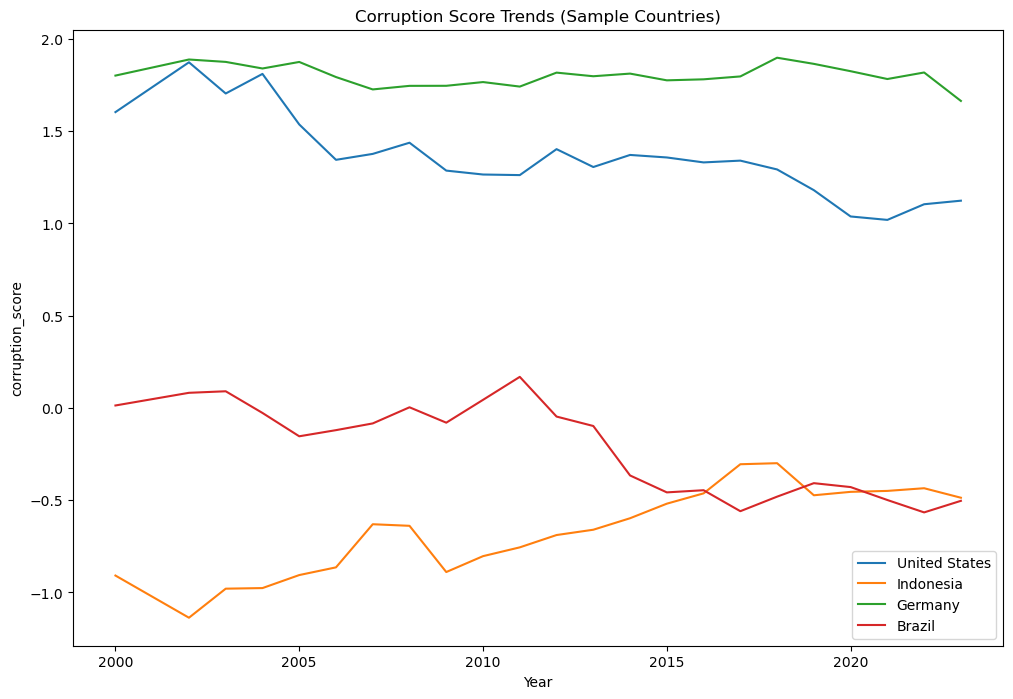

In [25]:
sample_countries = ['United States', 'Indonesia', 'Germany', 'Brazil']

plt.figure(figsize=(12, 8))
for country in sample_countries:
    data = df_merged[df_merged['Country'] == country]
    sns.lineplot(x=data['Year'], y=data['corruption_score'], label=country)
    
plt.title('Corruption Score Trends (Sample Countries)')
plt.legend()
plt.show()


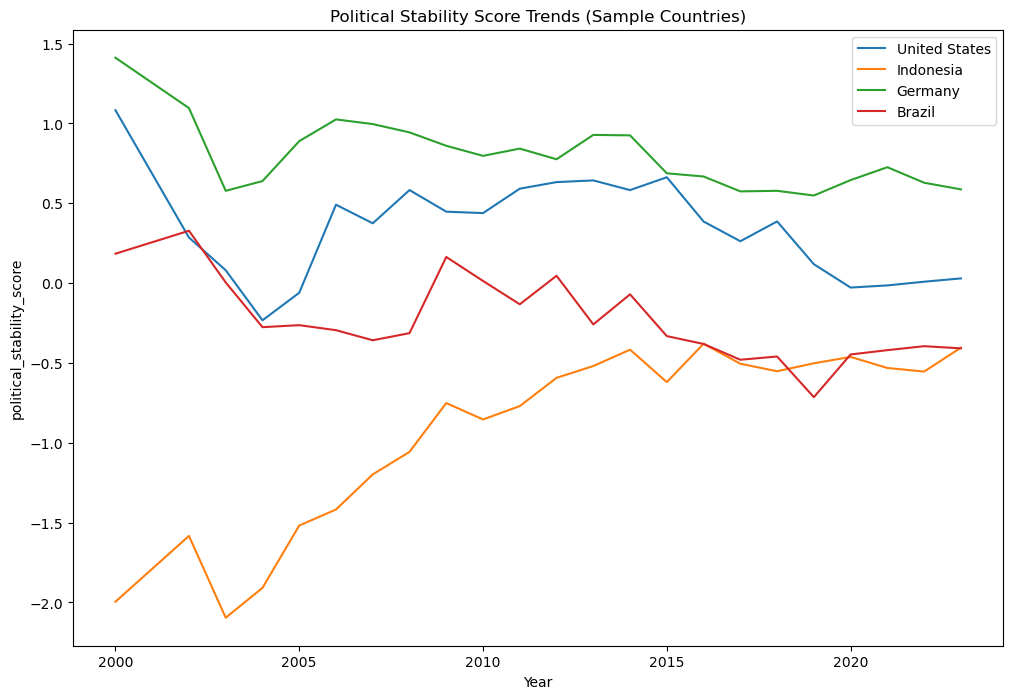

In [26]:
plt.figure(figsize=(12, 8))
for country in sample_countries:
    data = df_merged[df_merged['Country'] == country]
    sns.lineplot(x=data['Year'], y=data['political_stability_score'], label=country)
    
plt.title('Political Stability Score Trends (Sample Countries)')
plt.legend()
plt.show()

Since the the trends are too volatile and noisy for simple linear interpolation to make sense, we will do forward/backward fill instead. Governance scores tend to be stable over short periods — political structures don’t change drastically year-to-year. Forward/backward fill smooths out small gaps without distorting long-term patterns.

In [27]:
# Forward fill first, then backward fill (by country)
df_merged['corruption_score'] = df_merged.groupby('Country')['corruption_score'].ffill().bfill()
df_merged['political_stability_score'] = df_merged.groupby('Country')['political_stability_score'].ffill().bfill()

In [28]:
print(df_merged.head())

   Country  Year  FDI (% of GDP)  GDP Growth (%)  Inflation (%)  \
0  Albania  2000        4.108776        6.946217       0.050018   
1  Albania  2001        5.285433        8.293313       3.107588   
2  Albania  2002        3.104827        4.536524       7.770526   
3  Albania  2003        3.172708        5.528637       0.484003   
4  Albania  2004        4.750175        5.514668       2.280019   

   Trade Balance (% of GDP)  Unemployment (%) corruption_score  \
0                -23.223502            19.023        -0.855564   
1                -23.824202            18.570        -0.855564   
2                -26.633836            17.891        -0.845341   
3                -25.325788            16.985        -0.853787   
4                -22.612066            16.306        -0.723732   

  political_stability_score  
0                  -0.53999  
1                  -0.53999  
2                 -0.297719  
3                  -0.30978  
4                  -0.42726  


In [29]:
print(df_merged.describe())

              Year  FDI (% of GDP)  GDP Growth (%)  Inflation (%)  \
count  2781.000000     2781.000000     2781.000000    2781.000000   
mean   2011.637181        5.954782        3.524884       5.271459   
std       6.876634       25.232971        4.679628      10.636180   
min    2000.000000     -360.352807      -50.338515      -9.797647   
25%    2006.000000        1.167635        1.689798       1.616302   
50%    2012.000000        2.761406        3.728576       3.290291   
75%    2018.000000        5.222556        5.750832       6.412513   
max    2023.000000      452.221040       86.826748     359.093041   

       Trade Balance (% of GDP)  Unemployment (%)  
count               2781.000000       2781.000000  
mean                  -2.934904          7.704531  
std                   14.405445          5.303144  
min                 -139.353793          0.119000  
25%                   -8.990711          3.850000  
50%                   -1.599979          6.255000  
75%           

In [30]:
highest_trade_balance = df_merged.loc[df_merged['Trade Balance (% of GDP)'].idxmax()]
print(highest_trade_balance[['Year','Country', 'Trade Balance (% of GDP)']])

Year                             2006
Country                         Libya
Trade Balance (% of GDP)    45.940553
Name: 1563, dtype: object


Correlation Matrix

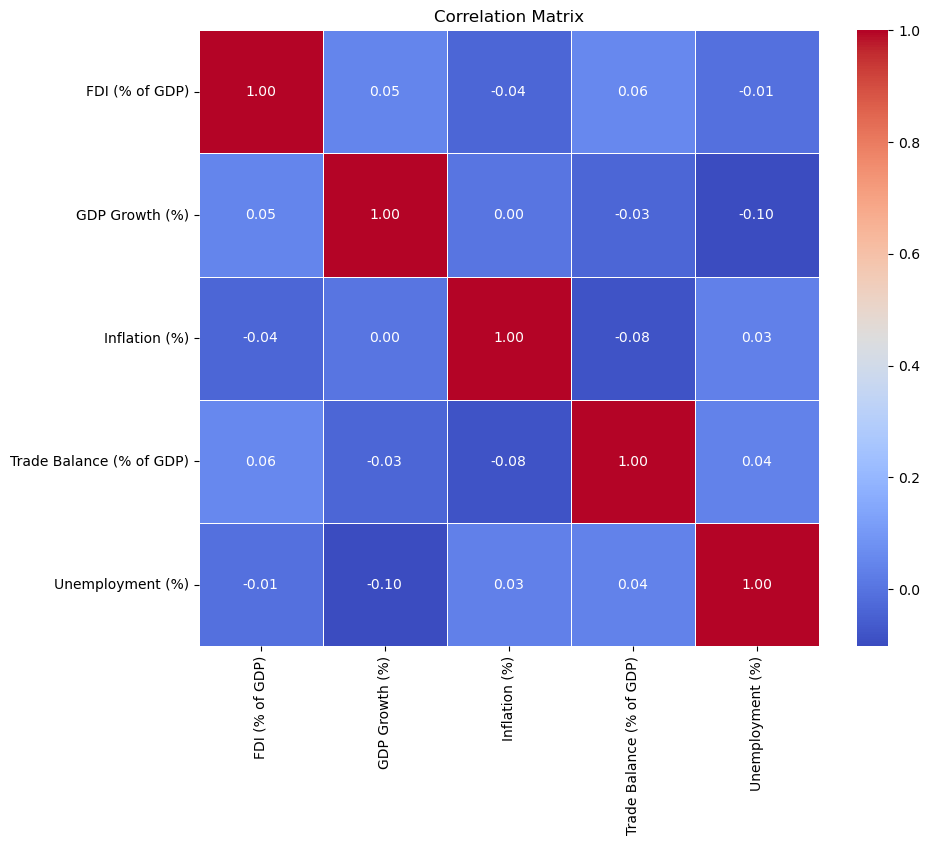

In [31]:
plt.figure(figsize=(10, 8))

# Keep only numeric columns
numeric_df = df_merged.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix on numeric data only
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()


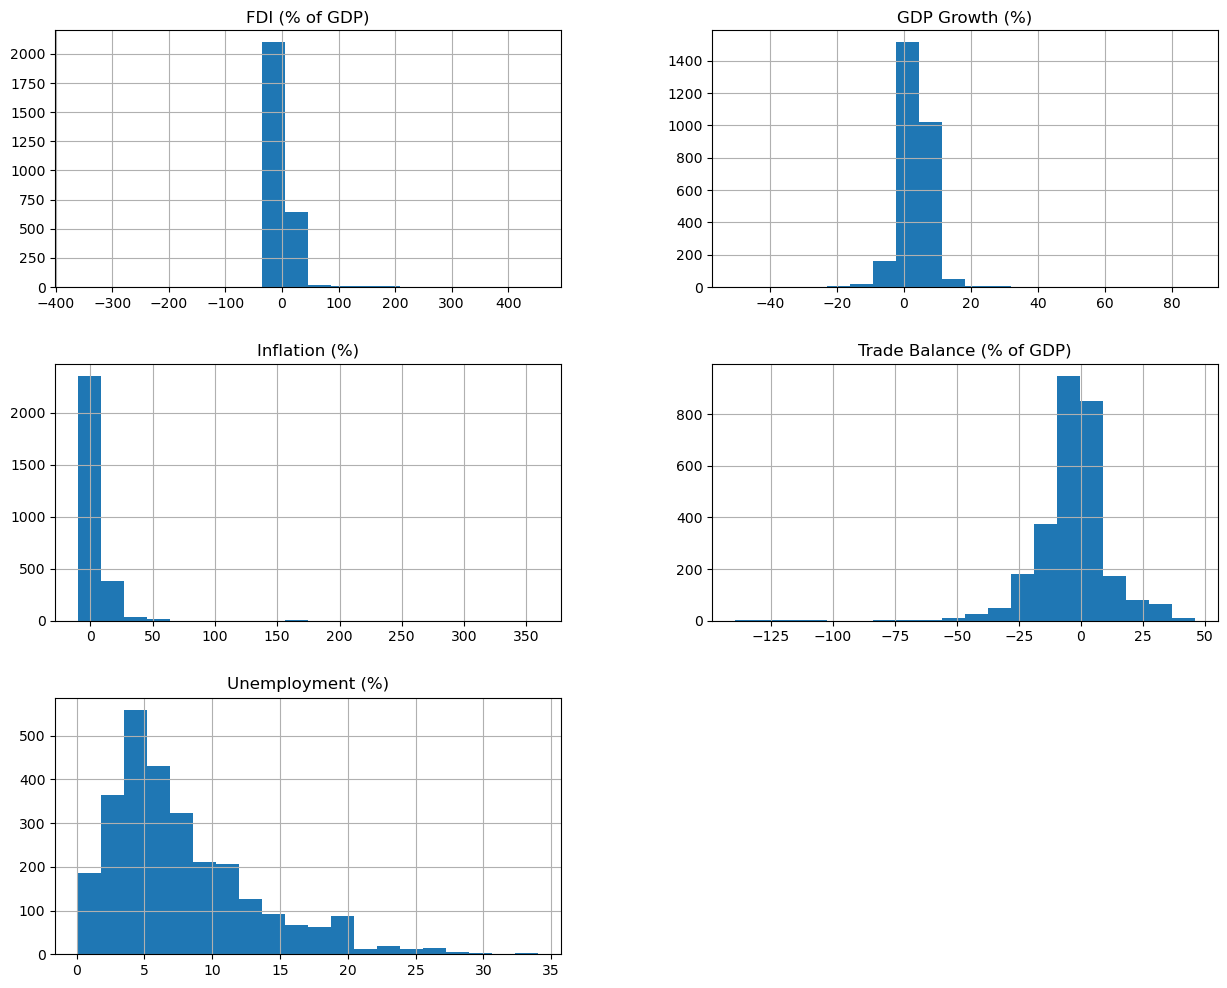

In [32]:
df_merged[['FDI (% of GDP)', 'GDP Growth (%)', 'Inflation (%)', 
           'Trade Balance (% of GDP)', 'Unemployment (%)',
           'corruption_score', 'political_stability_score']].hist(bins=20, figsize=(15, 12))
plt.show()


Scatter Plots

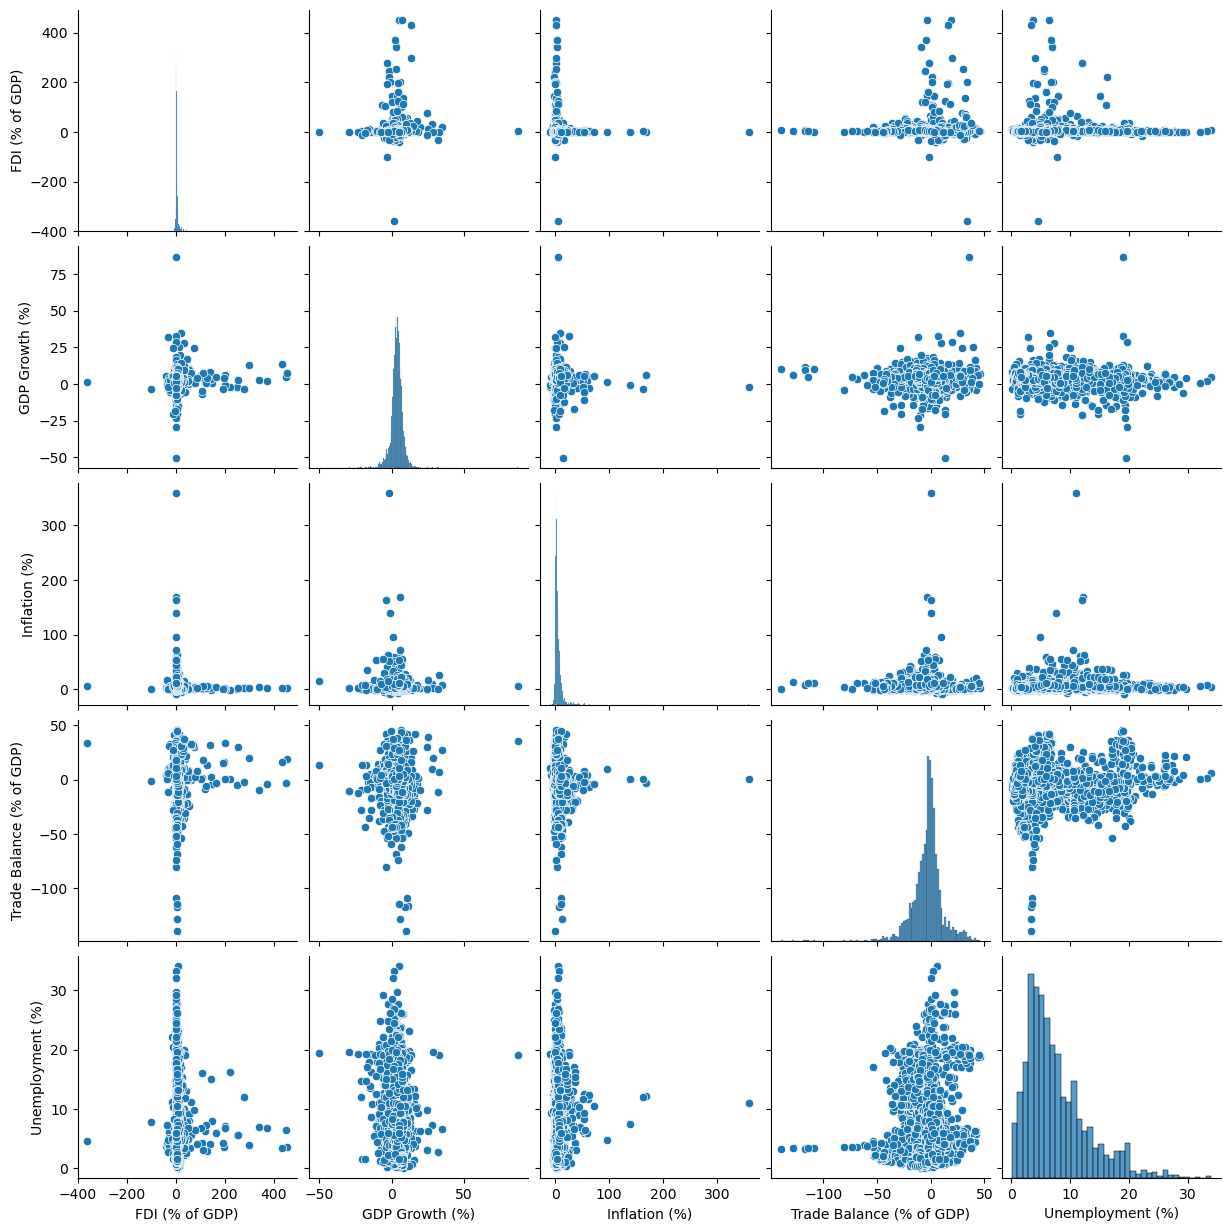

In [33]:
sns.pairplot(df_merged[['FDI (% of GDP)', 'GDP Growth (%)', 'Inflation (%)', 
                        'Trade Balance (% of GDP)', 'Unemployment (%)',
                        'corruption_score', 'political_stability_score']])
plt.show()

Handling outliers

From the pairplot, we can already see some extreme outliers:

- FDI (% of GDP) → Some countries have very large FDI percentages (over 200%) — probably financial hubs or tax havens.
- GDP Growth (%) → A few points showing growth rates beyond ±50% — likely data entry issues or extraordinary events (e.g., hyperinflation or post-crisis rebounds).
- Inflation (%) → Some very high spikes — possibly reflecting hyperinflation in unstable economies.

We’ll clip values at the 1st percentile and 99th percentile to avoid extreme values distorting the model

In [34]:
# Clip extreme outliers for FDI, GDP growth, inflation, trade balance, and unemployment
for col in ['FDI (% of GDP)', 'GDP Growth (%)', 'Inflation (%)', 
            'Trade Balance (% of GDP)', 'Unemployment (%)']:
    lower_bound = df_merged[col].quantile(0.01)
    upper_bound = df_merged[col].quantile(0.99)
    df_merged[col] = np.clip(df_merged[col], lower_bound, upper_bound)


In [35]:
# Select only numeric predictor variables
variables = df_merged[['FDI (% of GDP)', 'Inflation (%)', 'Unemployment (%)', 
                       'Trade Balance (% of GDP)', 'corruption_score', 'political_stability_score']]

# Calculate VIF for each variable
vif = pd.DataFrame()
vif['Variable'] = variables.columns
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

print(vif)

TypeError: '>=' not supported between instances of 'float' and 'str'

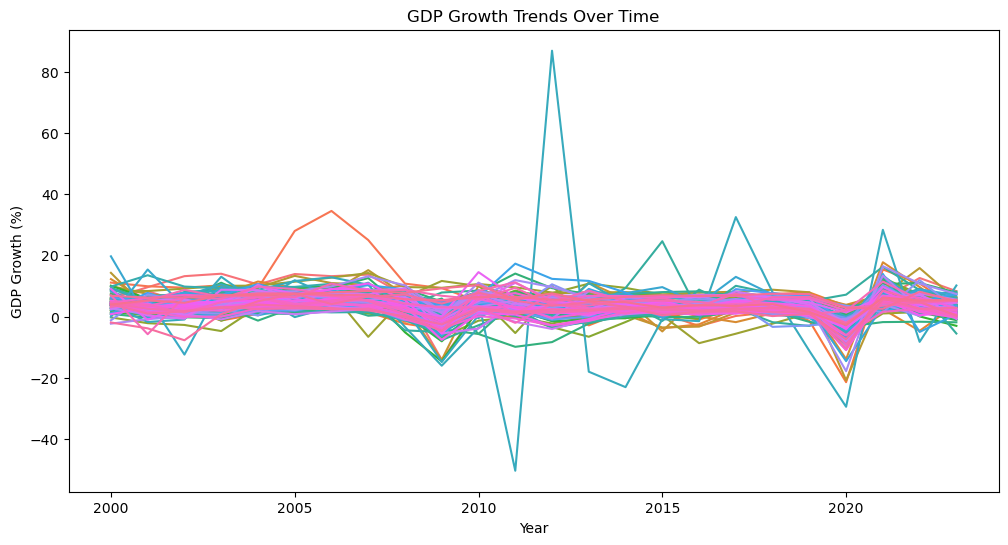

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='GDP Growth (%)', data=df_merged, hue='Country', legend=False)
plt.title("GDP Growth Trends Over Time")
plt.show()

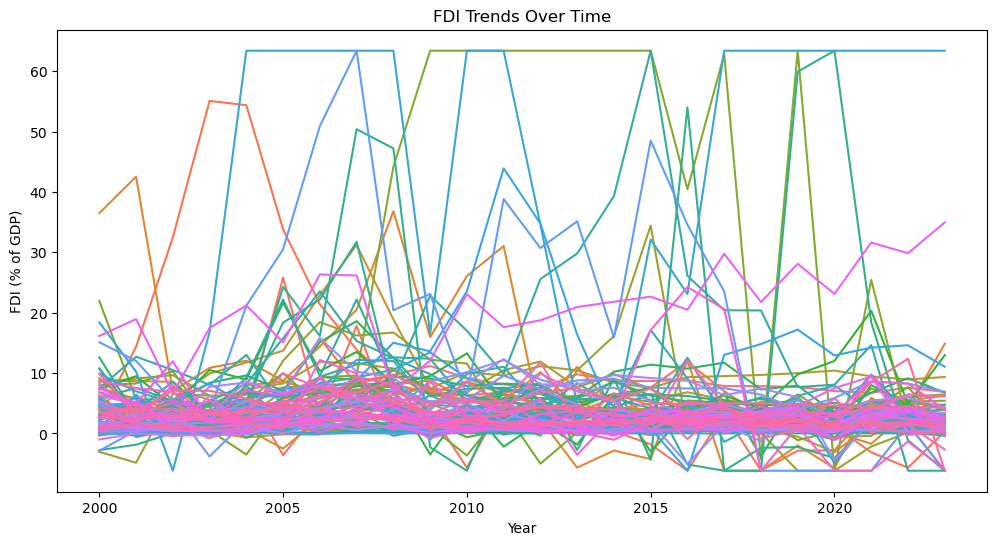

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='FDI (% of GDP)', data=df_merged, hue='Country', legend=False)
plt.title("FDI Trends Over Time")
plt.show()


Let's bin values into categories

In [ ]:
# Bin corruption and political stability into 3 levels
df_merged['corruption_level'] = pd.qcut(df_merged['corruption_score'], q=3, labels=['Low', 'Medium', 'High'])
df_merged['stability_level'] = pd.qcut(df_merged['political_stability_score'], q=3, labels=['Low', 'Medium', 'High'])

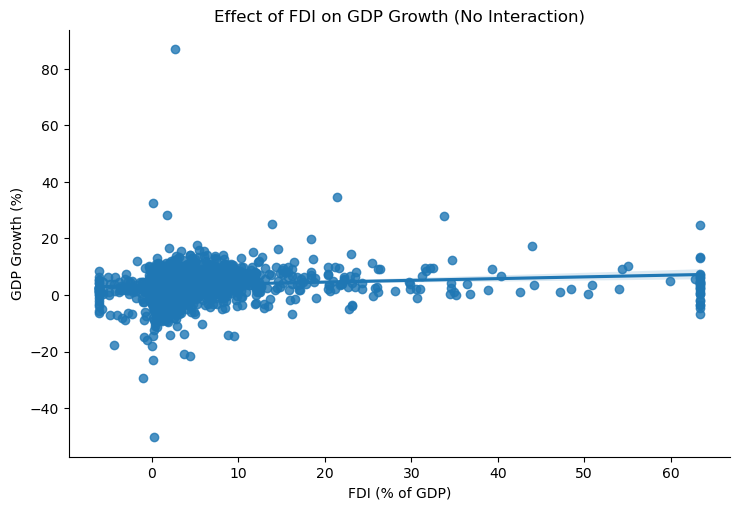

In [ ]:
sns.lmplot(x='FDI (% of GDP)', y='GDP Growth (%)',
           data=df_merged, aspect=1.5)
plt.title("Effect of FDI on GDP Growth (No Interaction)")
plt.show()


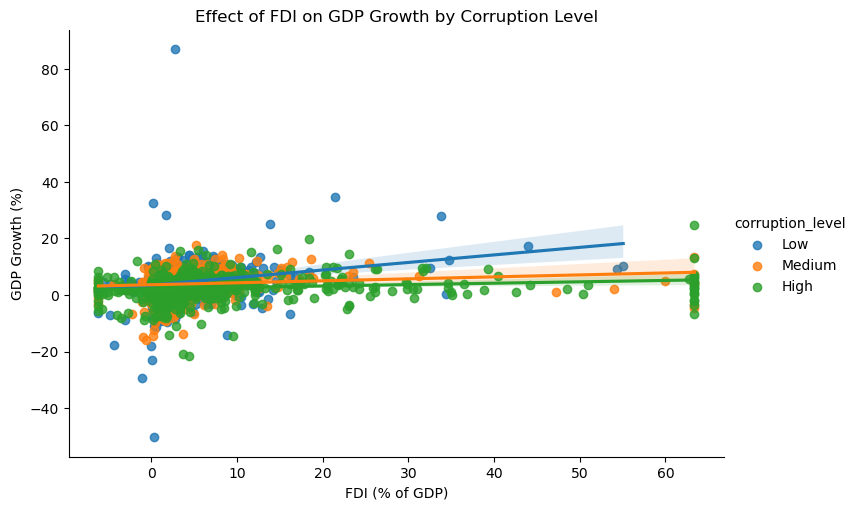

In [ ]:
sns.lmplot(x='FDI (% of GDP)', y='GDP Growth (%)', hue='corruption_level',
           data=df_merged, aspect=1.5)
plt.title("Effect of FDI on GDP Growth by Corruption Level")
plt.show()


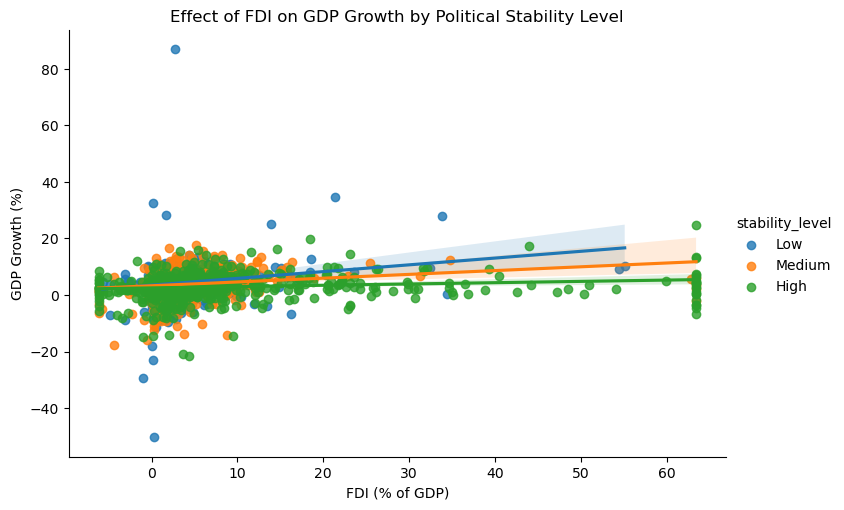

In [ ]:
sns.lmplot(x='FDI (% of GDP)', y='GDP Growth (%)', hue='stability_level',
           data=df_merged, aspect=1.5)
plt.title("Effect of FDI on GDP Growth by Political Stability Level")
plt.show()